In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set_theme()
%matplotlib inline

In [2]:
full_aum_df = pd.read_csv("BERT_AUM/full_aum_records.csv")
full_aum_df.rename({"sample_id": "example_id"}, axis=1, inplace=True)
full_aum_df.set_index("example_id", drop=True, inplace=True)
full_aum_df.head(10)

,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum,grads
example_id,,,,,,,,
0,1,0,2.549168,4,1.028855,1.520313,1.520313,0
0,2,0,2.979405,4,1.889235,1.090170,1.305242,0
0,3,0,3.836458,4,1.928314,1.908144,1.506209,0
0,4,0,4.374650,4,2.711658,1.662992,1.545405,0
0,5,0,4.143502,4,3.108989,1.034513,1.443227,0
1,1,0,-1.115942,3,2.316786,-3.432727,-3.432727,0
1,2,0,-0.735151,3,1.841867,-2.577019,-3.004873,0
1,3,0,-0.802320,3,0.941912,-1.744232,-2.584659,0
1,4,0,0.091652,3,2.530203,-2.438552,-2.548133,0


In [3]:
indicator_idxes = np.loadtxt("BERT_AUM/indicator_idxes.txt", delimiter="\n", dtype=int)
indicator_idxes

array([101412, 101413, 101414, ..., 121691, 121692, 121693])

In [4]:
all_final_recs = full_aum_df.loc[full_aum_df.num_measurements==5]
indicator_final_recs = all_final_recs.loc[indicator_idxes]
IND_QUANTILE_THRESH = 0.99
aum_filter_thresh = np.quantile(indicator_final_recs.aum, IND_QUANTILE_THRESH)
# for filtering the ambiguous and mislabeled 

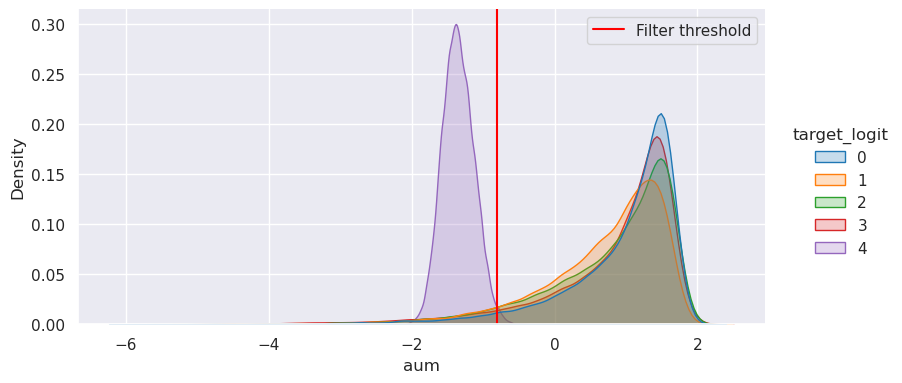

In [20]:
sns.displot(all_final_recs, x="aum", hue="target_logit", kind="kde", 
            bw_adjust=0.75, fill=True, height=4, aspect=2, palette="tab10")
plt.axvline(aum_filter_thresh, color="red", label="Filter threshold")
plt.legend()

In [21]:
real_recs = full_aum_df.loc[~full_aum_df.index.isin(indicator_idxes)]
final_real_recs = real_recs.loc[real_recs.num_measurements==5] 
final_ambi_recs = final_real_recs.loc[final_real_recs.aum < aum_filter_thresh]
ambi_example_ids = final_ambi_recs.index
ambi_example_ids

Int64Index([     1,     17,     37,     64,     65,     74,     88,     95,
                96,    106,
            ...
            101256, 101269, 101273, 101322, 101334, 101343, 101347, 101352,
            101394, 101411],
           dtype='int64', name='example_id', length=6842)

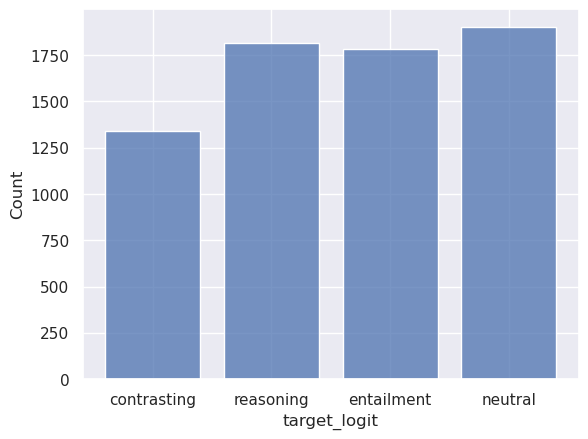

In [7]:
ax = sns.histplot(final_ambi_recs, x="target_logit",
                  discrete=True, shrink=0.8)
DATA_DIR = "SciNLI_dataset"
with open(f"{DATA_DIR}/label_map.json") as js_file:
    label_map = json.load(js_file)
ax.set_xticks(list(label_map.values()), list(label_map.keys()))
plt.show()

In [8]:
def margin_by_epochs(full_aum_df, example_id):
  target_val = full_aum_df.loc[example_id].target_val
  other_val = full_aum_df.loc[example_id].other_val
  epochs = full_aum_df.loc[example_id].num_measurements

  fig, ax = plt.subplots(figsize=(6, 3))
  ax.plot(epochs, target_val, "o--", label="Target")
  ax.plot(epochs, other_val, "o--", label="Other")
  ax.fill_between(epochs, target_val, other_val, 
                   where=(target_val > other_val), 
                   color="C0", alpha=0.3, interpolate=True)
  ax.fill_between(epochs, other_val, target_val, 
                   where=(other_val > target_val), 
                   color="C1", alpha=0.3, interpolate=True)  

  ax.legend(fontsize=8)
  ax.tick_params(axis="both", labelsize=8)
  ax.set_xticks(epochs)
  ax.set_ylabel("Logits", fontsize=8)
  ax.set_xlabel("Epochs", fontsize=8)

Margins of an indicator example:


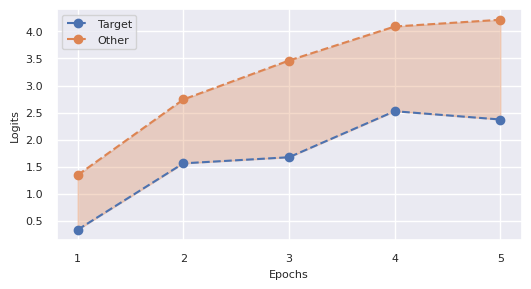

In [22]:
print("Margins of an indicator example:")
margin_by_epochs(full_aum_df, indicator_idxes[0])

In [23]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv").iloc[:, 2:]

["Our method for extracting sentences for PSTS is inspired by bilingual pivoting (Bannard and Callison-Burch, 2005), which discovers samelanguage paraphrases by ''pivoting'' over bilingual parallel corpora."
 'we use BERT in its configuration for sentence pair classification tasks, where the input consists of two tokenized sentences (c t and c w ), preceded by a [CLS] token and separated by a [SEP] token.'
 'neutral']


,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum,grads
example_id,,,,,,,,
101411,1,3,-0.497022,2,0.967292,-1.464314,-1.464314,0
101411,2,3,0.471179,2,1.699873,-1.228694,-1.346504,0
101411,3,3,-0.224853,2,2.050985,-2.275838,-1.656282,0
101411,4,3,-0.264853,2,2.548577,-2.813431,-1.945569,0
101411,5,3,2.524668,4,0.715518,1.809150,-1.194625,0


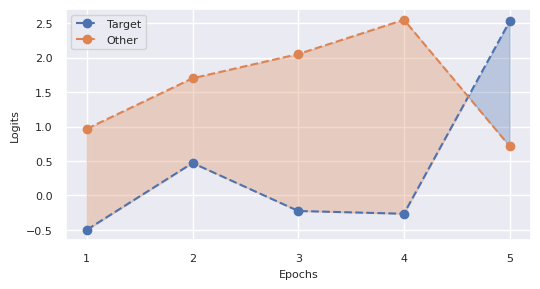

In [24]:
print(train_df.iloc[ambi_example_ids[-1]].values)
margin_by_epochs(full_aum_df, ambi_example_ids[-1])
full_aum_df.loc[ambi_example_ids[-1]]

['They also adopted sophisticated plan-based dialogue models as well at the initial stage of the project.'
 'the trend changed rather drastically in the early 90s and most research groups with practical applications in mind gave up such strategies and switched to more corpus-oriented and statistical methods.'
 'contrasting']


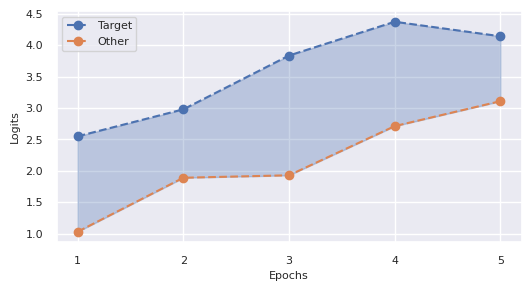

In [25]:
print(train_df.iloc[0].values)
margin_by_epochs(full_aum_df, 0)

<AxesSubplot:xlabel='target', ylabel='other'>

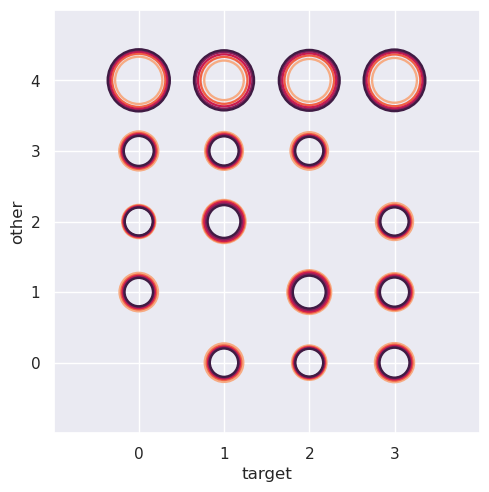

In [51]:
import itertools

def graph_confusion(aum_df, target_list, other_list, tot_epochs):
  false_neg_tracker = pd.DataFrame(columns=["target", "other", "epoch", "FN_ct"]) 
  epoch_list = [e for e in range(1, tot_epochs+1)]
  tar_other_ep_cross = itertools.product(target_list, other_list, epoch_list)
  for i, (tar, other, ep) in enumerate(tar_other_ep_cross):
    if tar!=other:
      false_neg_ct = ((aum_df.target_logit==tar) &
                      (aum_df.other_logit==other) &
                      (aum_df.num_measurements==ep)).sum()
      # not actually False Negative because the other logit can be << target logit
      false_neg_tracker.loc[i] = [tar, other, ep, false_neg_ct]

  fig = plt.gcf()
  fig.set_size_inches(5.5, 5.5)

  palette = dict(zip(range(tot_epochs, 0, -1), 
                     sns.color_palette(palette="rocket", n_colors=tot_epochs)))
  ec = false_neg_tracker.epoch.map(palette)
  ax = sns.scatterplot(data=false_neg_tracker, x="target", y="other", hue="epoch", size="FN_ct", 
                       sizes=(400, 2000), ec=ec, fc="none")
  ax.set_xlim(-1, 4)
  ax.set_ylim(-1, 5)
  ax.set_xticks(target_list)
  ax.set_yticks(other_list)
  ax.legend([],[], frameon=False)
  return ax

graph_confusion(full_aum_df, [0, 1, 2, 3], [0, 1, 2, 3, 4], 5)

In [9]:
# from sklearn.neighbors import KernelDensity
# final_aum_df = full_aum_df.loc[full_aum_df.num_measurements==5]
# final_contrast_df = final_aum_df.loc[final_aum_df.target_logit==0]
# final_contrast_aum = final_contrast_df["aum"].values
# final_contrast_aum.sort(axis=0)
# kde = KernelDensity(kernel='gaussian').fit(final_contrast_aum.reshape(-1,1))
# contrast_log_dens = kde.score_samples(final_contrast_aum.reshape(-1,1))

# fig, ax = plt.subplots(figsize=(6, 3))
# ax.plot(final_contrast_aum, np.exp(contrast_log_dens))